In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
dirs = {}
dirs['mnist'] = '/mnt/Data/Work/Sources/Petnica'
dirs['features'] = '/mnt/Data/Work/Sources/Petnica/features'

In [6]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root=dirs['mnist'], train=True, download=False, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [7]:
dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/5, Loss: 0.038585
Epoch 2/5, Loss: 0.029763
Epoch 3/5, Loss: 0.028515
Epoch 4/5, Loss: 0.024157
Epoch 5/5, Loss: 0.023906


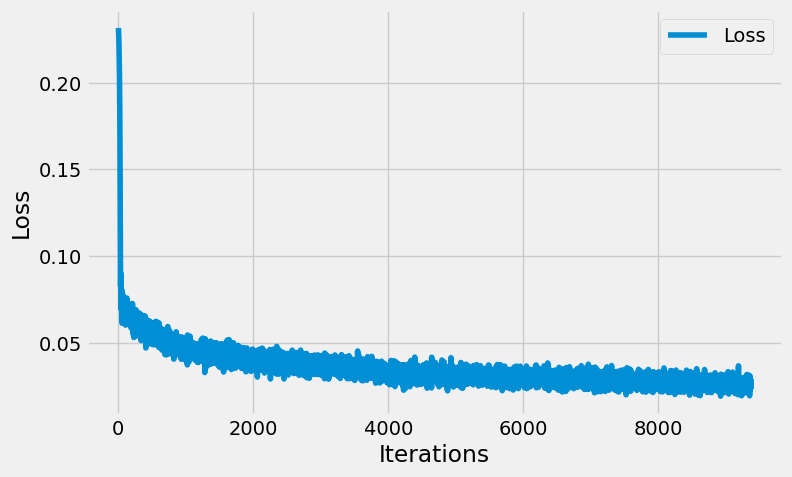

In [10]:
epochs = 5
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
loader2 = torch.utils.data.DataLoader(dataset=dataset, batch_size=300, shuffle=False)

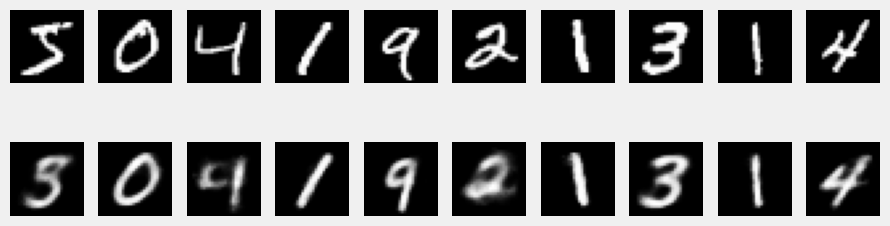

In [12]:
model.eval()
dataiter = iter(loader2)
images, _ = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

In [17]:
dataset.targets[:300]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5,
        0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3,
        0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5,
        8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
        9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5,
        7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3,

In [20]:
output_file = os.path.join(dirs['features'],'autoencoder_features_mnist.npy')
np.save(output_file, model.encoder(images).cpu().detach().numpy())

In [21]:
output_file = os.path.join(dirs['features'],'autoencoder_images_mnist.npy')
np.save(output_file,images.cpu().detach().numpy().reshape(len(images),28, 28))

In [33]:
dataset.targets[:300].flip(0)

tensor([6, 3, 4, 0, 8, 4, 0, 4, 3, 1, 4, 7, 5, 6, 9, 5, 0, 9, 3, 9, 3, 5, 2, 1,
        4, 6, 5, 4, 4, 1, 1, 2, 9, 5, 8, 9, 7, 2, 6, 0, 5, 7, 4, 6, 3, 3, 2, 2,
        1, 3, 0, 1, 9, 0, 8, 5, 7, 3, 6, 8, 5, 6, 4, 5, 3, 0, 2, 0, 1, 7, 0, 3,
        9, 9, 8, 1, 7, 4, 6, 2, 5, 6, 4, 0, 3, 7, 2, 7, 1, 0, 0, 1, 3, 0, 1, 6,
        3, 8, 1, 1, 2, 3, 8, 7, 9, 4, 7, 0, 5, 2, 2, 8, 2, 6, 7, 1, 9, 5, 3, 2,
        3, 2, 1, 9, 5, 1, 5, 9, 2, 9, 0, 7, 9, 4, 6, 4, 4, 9, 2, 8, 2, 7, 3, 0,
        6, 9, 9, 1, 6, 4, 3, 7, 6, 8, 5, 8, 2, 4, 7, 7, 4, 5, 8, 3, 3, 1, 9, 5,
        4, 3, 6, 1, 4, 6, 8, 1, 7, 2, 0, 2, 0, 0, 2, 9, 4, 0, 1, 1, 3, 9, 2, 0,
        3, 6, 1, 1, 7, 1, 7, 5, 1, 3, 8, 7, 0, 8, 6, 4, 7, 6, 4, 0, 9, 3, 8, 7,
        6, 2, 0, 9, 7, 1, 1, 2, 0, 3, 6, 1, 7, 1, 0, 0, 1, 6, 5, 4, 0, 6, 4, 4,
        1, 4, 9, 0, 8, 9, 4, 7, 0, 3, 3, 9, 5, 8, 9, 3, 9, 7, 8, 1, 6, 7, 0, 6,
        5, 0, 9, 6, 8, 3, 7, 2, 3, 4, 2, 1, 1, 9, 0, 4, 9, 6, 8, 2, 7, 1, 6, 3,
        5, 3, 4, 1, 3, 1, 2, 9, 1, 4, 0,

In [22]:
output_file = os.path.join(dirs['features'],'mnist_labels.npy')
np.save(output_file, dataset.targets[:300].flip)